In [43]:
import os
import sys

def add_to_sys_path(relative_path):
    abs_path = os.path.abspath(os.path.join(os.getcwd(), relative_path))
    if abs_path not in sys.path:
        sys.path.append(abs_path)

add_to_sys_path(os.path.join('..', '..', '..', 'Utils'))
add_to_sys_path(os.path.join('..', '..', '..', 'Model'))
add_to_sys_path(os.path.join('..', '..', '..', 'alg'))

In [44]:
import pandas as pd
import numpy as np
import random
import shap

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

from algorithm import *
from explainer import *
from genetic import *
import dalex as dx
from LR import base_model as base_model_call
from model_data_processing import Data_Handler, Model_Metrics_Visualizer

In [45]:
data = pd.read_csv('../../../Dataset/PhiUSIIL_Phishing_URL_Dataset.csv')
data.head()

,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,...,0,0,1,34,20,28,119,0,124,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,...,0,0,1,50,9,8,39,0,217,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,...,0,0,1,10,2,7,42,2,5,1
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,...,1,1,1,3,27,15,22,1,31,1
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,...,1,0,1,244,15,34,72,1,85,1


In [46]:
data = data.drop(data.select_dtypes(include='object').columns, axis=1)
data.head()

,URLLength,DomainLength,IsDomainIP,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,HasObfuscation,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,31,24,0,100.0,1.000000,0.522907,0.061933,3,1,0,...,0,0,1,34,20,28,119,0,124,1
1,23,16,0,100.0,0.666667,0.032650,0.050207,2,1,0,...,0,0,1,50,9,8,39,0,217,1
2,29,22,0,100.0,0.866667,0.028555,0.064129,2,2,0,...,0,0,1,10,2,7,42,2,5,1
3,26,19,0,100.0,1.000000,0.522907,0.057606,3,1,0,...,1,1,1,3,27,15,22,1,31,1
4,33,26,0,100.0,1.000000,0.079963,0.059441,3,1,0,...,1,0,1,244,15,34,72,1,85,1


In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235795 entries, 0 to 235794
Data columns (total 51 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   URLLength                   235795 non-null  int64  
 1   DomainLength                235795 non-null  int64  
 2   IsDomainIP                  235795 non-null  int64  
 3   URLSimilarityIndex          235795 non-null  float64
 4   CharContinuationRate        235795 non-null  float64
 5   TLDLegitimateProb           235795 non-null  float64
 6   URLCharProb                 235795 non-null  float64
 7   TLDLength                   235795 non-null  int64  
 8   NoOfSubDomain               235795 non-null  int64  
 9   HasObfuscation              235795 non-null  int64  
 10  NoOfObfuscatedChar          235795 non-null  int64  
 11  ObfuscationRatio            235795 non-null  float64
 12  NoOfLettersInURL            235795 non-null  int64  
 13  LetterRatioInU

In [48]:
protected_feature = 'IsHTTPS'

In [ ]:
x_train, x_test, y_train, y_test, feature_names, scaler = Data_Handler(
        df=data,
        target_column='label',
        protected_feature=protected_feature,
        do_scaling=True,
        correlation_threshold=0.35,
        test_size=0.3,
        random_state=0
    )


Applying feature correlation removal...


Scaling numerical features: ['URLLength', 'DomainLength', 'TLDLegitimateProb', 'LineOfCode', 'LargestLineLength', 'NoOfPopup', 'NoOfiFrame', 'NoOfCSS', 'NoOfEmptyRef']


In [50]:
print(len(x_train.columns))
x_train.head()

19


,URLLength,DomainLength,IsDomainIP,TLDLegitimateProb,HasObfuscation,IsHTTPS,LineOfCode,LargestLineLength,Robots,NoOfURLRedirect,NoOfPopup,NoOfiFrame,HasExternalFormSubmit,HasPasswordField,Bank,Pay,Crypto,NoOfCSS,NoOfEmptyRef
98258,-0.134650,0.059642,0,-0.922760,0,1,-0.185396,-0.077576,0,0,-0.053741,0.067997,0,0,0,0,0,-0.015936,0.032389
131577,-0.231504,-0.379189,0,-0.922760,0,1,0.422297,-0.074531,0,0,-0.053741,-0.095874,0,0,0,0,0,-0.060824,0.350060
201592,-0.183077,-0.159773,0,1.041476,0,1,0.180121,-0.075475,1,0,-0.053741,-0.259745,0,0,0,0,0,-0.049602,0.032389
159643,-0.134650,0.059642,0,-1.028299,0,1,1.472474,-0.056584,0,0,-0.053741,3.345417,0,1,1,1,0,-0.049602,0.138279
170726,-0.328358,-0.818020,0,-0.964647,0,1,-0.184108,-0.016243,1,0,-0.053741,0.067997,0,0,1,0,1,0.230949,-0.020556


In [51]:
feature_names

['URLLength',
 'DomainLength',
 'IsDomainIP',
 'TLDLegitimateProb',
 'HasObfuscation',
 'IsHTTPS',
 'LineOfCode',
 'LargestLineLength',
 'Robots',
 'NoOfURLRedirect',
 'NoOfPopup',
 'NoOfiFrame',
 'HasExternalFormSubmit',
 'HasPasswordField',
 'Bank',
 'Pay',
 'Crypto',
 'NoOfCSS',
 'NoOfEmptyRef']

In [52]:
# Assuming X_train, X_test, y_train, y_test are already separated
# And df is the original DataFrame with its original column names (e.g., 'thalach', 'trestbps', 'chol')

# Define VARIABLES_TO_CHANGE using the original column names
VARIABLES_TO_CHANGE = ['URLLength', 'DomainLength', 'TLDLegitimateProb', 'LineOfCode', 'LargestLineLength', 'NoOfPopup', 'NoOfiFrame', 'NoOfCSS', 'NoOfEmptyRef']

# Define the full list of columns you want to select for your features
selected_columns = [protected_feature] + VARIABLES_TO_CHANGE

# Apply the column selection to X_train and X_test
x_train = x_train.loc[:, selected_columns]
x_test = x_test.loc[:, selected_columns]

# y_train and y_test remain unchanged as they already contain the target variable

Accuracy: 0.9920270289373613
Precision: 0.9920263659392934
Recall: 0.9920270289373613
F-1: 0.9920264052758709


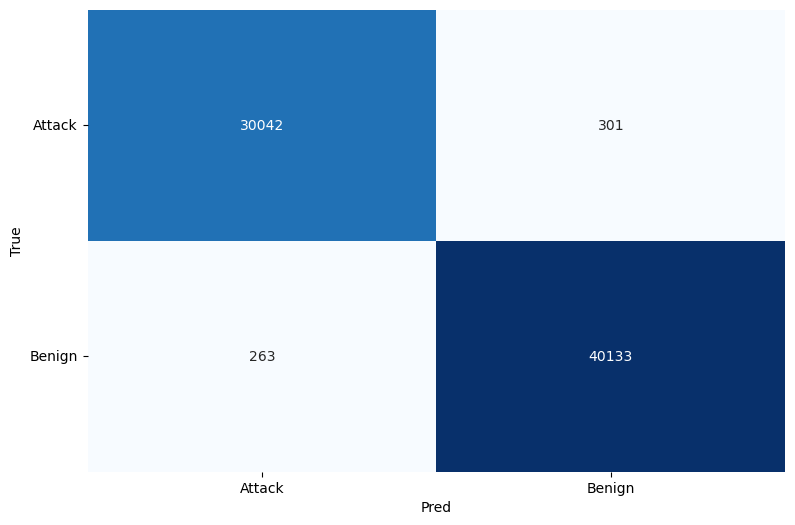

In [53]:
model = base_model_call(x_train, y_train, protected_feature, True)
y_pred = model.predict(x_test)
Model_Metrics_Visualizer(y_test, y_pred)

In [54]:
explainer = Explainer(model, x_test[:300], 'l')

In [55]:
e = dx.Explainer(model, x_test[:300], y_test[:300], verbose=False)
e.model_performance()

,recall,precision,f1,accuracy,auc
LogisticRegression,0.994413,1.0,0.997199,0.996667,0.999908


In [56]:
# pd.DataFrame({'variable': x_train.columns, 'importance_split': model.feature_importances_,
#               'importance_shap': explainer.shap_values(explainer.data),
#               'importance_perm': e.model_parts(B=25).result.sort_values("variable").iloc[2::,:].dropout_loss})


In [57]:
I = 36
a = GeneticAlgorithm(explainer, constant=[protected_feature], row_id=I)
e.data.iloc[[I]].assign(y=e.y[[I]], y_hat=e.y_hat[[I]])

,IsHTTPS,URLLength,DomainLength,TLDLegitimateProb,LineOfCode,LargestLineLength,NoOfPopup,NoOfiFrame,NoOfCSS,NoOfEmptyRef,y,y_hat
187014,1,-0.304144,-0.708312,1.041476,-0.186684,-0.043,-0.053741,0.067997,-0.060824,-0.020556,1,0.993107


In [58]:
print(a._x.shape, a._X.shape)

(10,) (300, 10)


In [59]:
a = GeneticAlgorithm(explainer, constant=[protected_feature], row_id=I, alpha=0.75, pop_count=100)
print(a._X.shape, a._x.shape)
t = a.explainer.shap_values(a._X)
print(t)
t = np.array([i + (t[0] / (len(t) - 3)) if i > 0 else i - (t[0] / (len(t) - 3)) for i in t])
t[0] = -0.005
pd.DataFrame({'variable': a.explainer.data.columns, 'shap_values': a.explainer.shap_values(a._X), 'target': t})

(300, 10) (10,)
[2.23561027 6.85217941 1.25504314 0.21030821 8.9500837  0.56311457
 0.12909702 1.703661   0.73298622 0.64004263]


,variable,shap_values,target
0,IsHTTPS,2.235610,-0.005000
1,URLLength,6.852179,7.171552
2,DomainLength,1.255043,1.574416
3,TLDLegitimateProb,0.210308,0.529681
4,LineOfCode,8.950084,9.269457
5,LargestLineLength,0.563115,0.882487
6,NoOfPopup,0.129097,0.448470
7,NoOfiFrame,1.703661,2.023034
8,NoOfCSS,0.732986,1.052359
9,NoOfEmptyRef,0.640043,0.959416


In [60]:
t.shape

(10,)

In [69]:
a.fool_aim(target=np.array(t), max_iter=300, random_state=0)

  0%|          | 0/200 [00:00<?, ?it/s]

Iter: 200 || Loss: 0.5453750196917776: 100%|██████████| 200/200 [04:38<00:00,  1.39s/it]


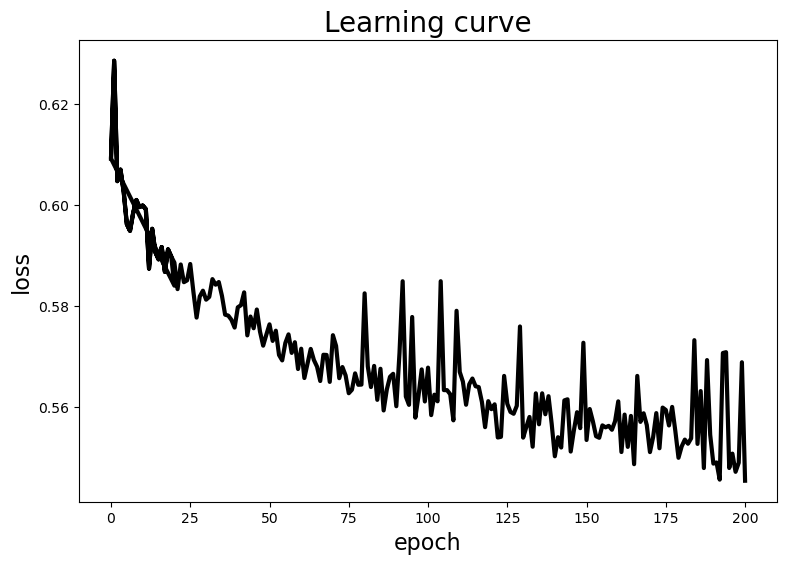

In [70]:
a.plot_losses()

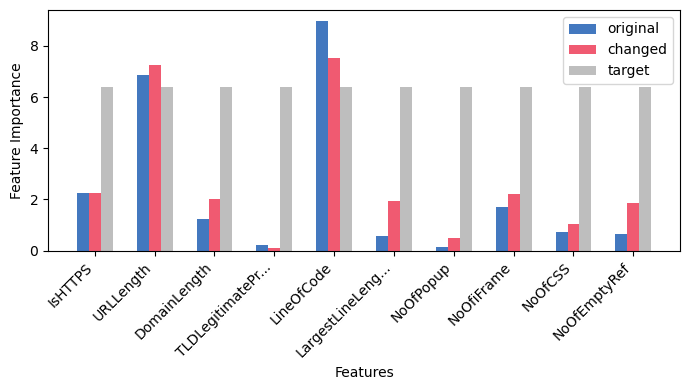

In [71]:
a.plot_explanation()

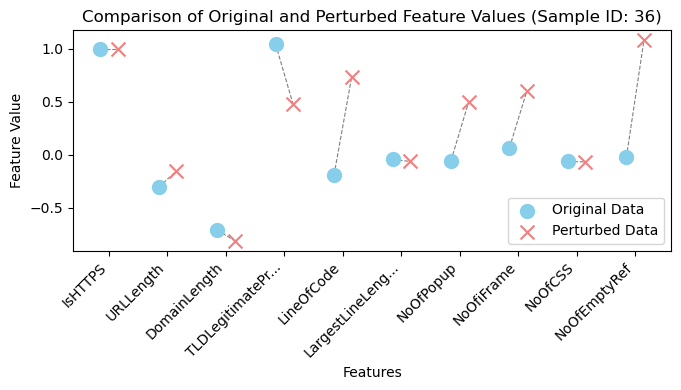

In [72]:
a.plot_data()

In [73]:
a = GeneticAlgorithm(explainer, constant=[protected_feature], row_id=I, alpha=0.75, pop_count=100)
t = a.explainer.shap_values(a._X)
# print(t)
t = np.array([i*0+np.mean(t)*2.75 for i in t])
# t[0] = -0.005
pd.DataFrame({'variable': a.explainer.data.columns, 'shap_values': a.explainer.shap_values(a._X), 'target': t})

,variable,shap_values,target
0,IsHTTPS,2.235610,6.399835
1,URLLength,6.852179,6.399835
2,DomainLength,1.255043,6.399835
3,TLDLegitimateProb,0.210308,6.399835
4,LineOfCode,8.950084,6.399835
5,LargestLineLength,0.563115,6.399835
6,NoOfPopup,0.129097,6.399835
7,NoOfiFrame,1.703661,6.399835
8,NoOfCSS,0.732986,6.399835
9,NoOfEmptyRef,0.640043,6.399835


In [74]:
a.fool_aim(target=np.array(t), max_iter=200, random_state=0)

  0%|          | 0/200 [00:00<?, ?it/s]

Iter: 200 || Loss: 0.5453750196917776: 100%|██████████| 200/200 [04:27<00:00,  1.34s/it]


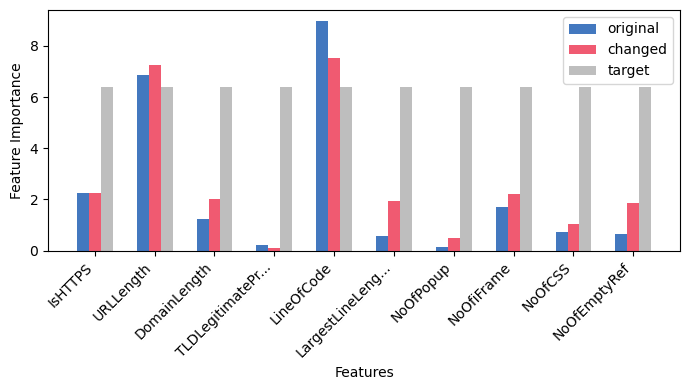

In [75]:
a.plot_explanation()

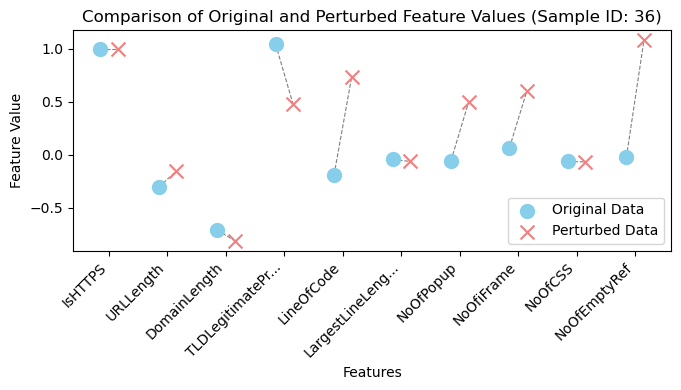

In [76]:
a.plot_data()

In [ ]:
a.display_feature_rank_changes()